# Sentiment Analysis: Quantification of Financial Documents

The efficient market hypothesis assumes that the market price is reflective of all available information about a given asset. Markets over the last few decades, as reflected by hedge funds’ recent inabilities to outperform their benchmarks, have become more efficient. However, pockets of inefficiency remain related to the processing of market participants’ sentiment on individual assets or classes of assets. Indeed, sentiment can be seen as a real-time interpretation of the information being brought to the market by different players. For example, in earnings calls or securities filings, this is management bringing their views into the market. On social media, this could include individual investors on different platforms voicing their sentiment on a given stock, which could indicate the market actions (i.e. buy, sell, hold) they may pursue. Monitoring and identifying discrepancies between raw information and the sentiment of these actors is invaluable in capturing the remaining alpha in financial markets.

## Today's Tasks: Going from an ACCURACY of 33.33% to more than 80%

Today, we will build simple models, that will show the importance of context in unstructed financial datasets. The models will take as an input any financial statement (e.g. "Assets in the private credit industry today total more than $600 billion, up about six fold since the year 2000.") and quantify it.

In the following exercise, we will start with a simple statistical model (Financial-Sentiment-V1), where we use pre-trained Word Embeddings (GloVe) to represent each word in the corpus and combine these embeddings to obtain the sentiment. Later, we will build more sophisticated models (Financial-Sentiment-V2 and Financial-Sentiment-V3) that further incorporates Recurrent Neural Network (RNN) and Long Short Term Memory Units (LSTM).

## 1. Financial-Sentiment-V1

Let's load the required packages on this notebook. Press Shift+Enter on each cell to execute them.

In [1]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.special import softmax
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### 1.1 Dataset (Samples from Earnings Call)

Let's load the dataset using the code below. 
The dataset contains 14727 sentences (strings) and their corresponding integer labels between -1 and 1 (-1:Negative; 0:Neutral; 1:Positive). 

<img src='SampleData.png'>

In [2]:
Data = pd.read_csv('EC_Data.csv')
X = list(Data['Sentence'])
Y = Data['MyScore']

To see other sentences in the dataset, you can change $index$ below and run the cell to print sentences from X and corresponding labels from Y. 

In [3]:
index = 10
print(X[index], (Y[index]))

Our tactical opportunities business raised $700 million during the quarter, had an additional closing in October, which, as Tony mentioned, brought the strategy to $4.4 billion in size, which is really good for a start-up type of business that doesn't fit any particular vertical silo in the institutional community it invests across. 1


### 1.2 - Overview of the Financial-Sentiment-V1

In this part, we are going to implement a baseline statistical model called "Financial-Sentiment-V1".

The input for this case will be any sentence from our dataset (e.g. "Assets in the private credit industry today total more than $600 billion, up about six fold since the year 2000"), and the output will be a vector of shape (3,1) where each value will be the probability of the class being true, that is then passed to an argmax layer to extract the index of the most likely output.

Being a classification problem, we will convert our labels to normalize them for the softmax classifier. Let's convert $Y$ ($(m, 1)$) into a "one-hot representation" $(m, 3)$, where each row is a one-hot vector giving the label of one example.

In [4]:
LB = LabelBinarizer()
LB.fit(Y)
Y_OH = LB.transform(Y)

In [5]:
index = 1
print(Y[index], "is converted into one hot", Y_OH[index])

1 is converted into one hot [0 0 1]


### 1.3 - Implementing Financial-Sentiment-V1


### 1.3.1 Feature Representation of Text

In almost all NLP tasks, the first step is to convert input text into a representation that the machine can process. There are multiple ways to represent text, some statistical and some contextual. Below we will go through a few ways to represent any text dataset to understand how these work.

#### Count Vectors

At the most basic level, Count Vectors represent the $count$ of each word in an example. We build a dictionary of every word present in the dataset, and then each count vector has the size $(C,1)$, where $C$ is the size of the dictionary. Given such a representation, the words in each sentence are jumbled and thus lose a lot of the contextual information in the data. Let's see an example below.

In [6]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

# fit the data using count vectorizer object
count_vect.fit(X)
    
# transform the data using count vectorizer object
X_count =  count_vect.transform(X)

Let's look at what the count vectors look like for a sample of the data.

In [7]:
vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
Sample_Count = vectorizer.fit_transform(X[:5])
print(X[:5])
print(vectorizer.get_feature_names())
print(Sample_Count.toarray())  

['Stock markets in the U. S. which initially declined up to 8%, have now recovered in only three weeks to regain record levels.\nInterest rates have started to decline slowly as market peaks, as investors recognize that the Fed will act with prudence, not to stifle the economic recovery.', 'This receivable, contrary to what you might think, actually increased from the previous year despite our very substantial payout of distributions over the same period.', 'While a challenging single quarter for the industry and for us, on a long-term basis, as Steve have mentioned, BAAM has delivered net returns 50% greater than the market with about one-third of the volatility over the past 15 years.', "Finally, I'd like to highlight an important emerging dimension confirms business and economic model that is important to consider pertaining to new businesses like Real Estate core+ and Core Private Equity, which together will be approaching $17 billion in the second quarter, up from zero just over t

#### TF-IDF Vectors

Term Frequency - Inverse Document Frequency (TF-IDF) vector representation accounts for the the most commonly occuring words in a document which empirically do not provide much information. We can think of this representation as 'Normalizing the Count Vectors' with respect to the document frequency, where document frequency is the number of documents containing that term out of the total number of documents. 

For both Count Vectors and TF-IDF Vectors, we can also convert the document based on co-occuring words (n-grams) or even the character level. 

Let's see an example of TF-IDF Vectors below.

In [8]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X)
X_tfidf =  tfidf_vect.transform(X)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(X)
X_tfidf_ngram =  tfidf_vect_ngram.transform(X)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X)
X_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X)

In [9]:
# word level tf-idf
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
Sample_Count = vectorizer.fit_transform(X[:5])
print(X[:5])
print(vectorizer.get_feature_names())
print(Sample_Count.shape)
print(Sample_Count.toarray())  

['Stock markets in the U. S. which initially declined up to 8%, have now recovered in only three weeks to regain record levels.\nInterest rates have started to decline slowly as market peaks, as investors recognize that the Fed will act with prudence, not to stifle the economic recovery.', 'This receivable, contrary to what you might think, actually increased from the previous year despite our very substantial payout of distributions over the same period.', 'While a challenging single quarter for the industry and for us, on a long-term basis, as Steve have mentioned, BAAM has delivered net returns 50% greater than the market with about one-third of the volatility over the past 15 years.', "Finally, I'd like to highlight an important emerging dimension confirms business and economic model that is important to consider pertaining to new businesses like Real Estate core+ and Core Private Equity, which together will be approaching $17 billion in the second quarter, up from zero just over t

In [10]:
# ngram level tf-idf
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
Sample_Count = vectorizer.fit_transform(X[:5])
print(X[:5])
print(vectorizer.get_feature_names())
print(Sample_Count.shape)
print(Sample_Count.toarray())  

['Stock markets in the U. S. which initially declined up to 8%, have now recovered in only three weeks to regain record levels.\nInterest rates have started to decline slowly as market peaks, as investors recognize that the Fed will act with prudence, not to stifle the economic recovery.', 'This receivable, contrary to what you might think, actually increased from the previous year despite our very substantial payout of distributions over the same period.', 'While a challenging single quarter for the industry and for us, on a long-term basis, as Steve have mentioned, BAAM has delivered net returns 50% greater than the market with about one-third of the volatility over the past 15 years.', "Finally, I'd like to highlight an important emerging dimension confirms business and economic model that is important to consider pertaining to new businesses like Real Estate core+ and Core Private Equity, which together will be approaching $17 billion in the second quarter, up from zero just over t

In [11]:
# characters level tf-idf
vectorizer = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
Sample_Count = vectorizer.fit_transform(X[:5])
print(X[:5])
print(vectorizer.get_feature_names())
print(Sample_Count.shape)
print(Sample_Count.toarray())  

['Stock markets in the U. S. which initially declined up to 8%, have now recovered in only three weeks to regain record levels.\nInterest rates have started to decline slowly as market peaks, as investors recognize that the Fed will act with prudence, not to stifle the economic recovery.', 'This receivable, contrary to what you might think, actually increased from the previous year despite our very substantial payout of distributions over the same period.', 'While a challenging single quarter for the industry and for us, on a long-term basis, as Steve have mentioned, BAAM has delivered net returns 50% greater than the market with about one-third of the volatility over the past 15 years.', "Finally, I'd like to highlight an important emerging dimension confirms business and economic model that is important to consider pertaining to new businesses like Real Estate core+ and Core Private Equity, which together will be approaching $17 billion in the second quarter, up from zero just over t

#### Word Embeddings
Word embeddings are generally obtained by building a network that can predict the next word, given a part of the sentence. Therefore, these word embeddings generally have contextual meaning hidden in them. Given properly trained word embeddings, they are able to capture similarities between different words. For example, $King:Queen::Man:?$ should produce $Woman$. Thus these word embeddings provide much more meaning to the represetation ofthe dataset. 

Below, we will use pretrained 50-dimensional GloVe embeddings for our task (Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.). Run the following cell to load the pre-trained word-vector representations.

In [12]:
glove_file = '/srv/data/shared_data/glove.6B.50d.txt'
with open(glove_file, 'r') as f:
    words = set()
    word_embedding = {}
    for line in f:
        line = line.strip().split()
        curr_word = line[0]
        words.add(curr_word)
        word_embedding[curr_word] = np.array(line[1:], dtype=np.float64)
        
    i = 1
    word_to_index = {}
    index_to_word = {}
    for w in sorted(words):
        word_to_index[w] = i
        index_to_word[i] = w
        i = i + 1

We also need to clean up the text to remove unnecessary characters in the data, as well as standardize the data with respect to textcase. The function below implements this.

In [13]:
def clean_document(s):
    punctuation = string.punctuation.replace("$","")
    punctuation = punctuation.replace("%","")
    punctuation = punctuation.replace(".","")
    regex = re.compile('[%s]' % re.escape(punctuation + '\n\n' + '\t\t'))
    doco_clean = regex.sub('', s)
    doco_clean = doco_clean.split(' ');
    doco_clean = [word.lower() for word in doco_clean if len(word) > 0];
    return doco_clean;

# X_train_clean = [clean_document(doc) for doc in X_train];
# sentences = [' '.join(r) for r in X_train_clean]

### 1.3.2 The Model for Financial-Sentiment-V1

The model below converts each word in a sentence in to the respective word embedding vectors and averages them out. This is a very basic model where we will see that a Bag-Of-Words approach again loses the context in the data, since the averaging of all vectors does not keep the ordering of words in place. Therefore, while the word embeddings themselves were useful, averaging them out loses information.


<img src='BOW.png'>

In [14]:
def sentence_to_avg(sentence, word_embedding):
    
    # Step 1: Clean the sentence for unwanted punctuations
    clean_sentence = clean_document(sentence)
    clean_sentence = ' '.join(clean_sentence)
    # Step 2: Split sentence into list of words
    words = [i for i in clean_sentence.split()]

    # Initialize the average word vector, should have the same shape as your word vectors.
    average = np.zeros((50,))
    
    # Step 3: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        if w in word_embedding:
            average += word_embedding[w]
    average = average / len(words)
    
    return average

In [15]:
avg = sentence_to_avg("We completed two acquisitions during the year adding a 3 million gallon motor-fuel business to our mix and a bolt-on acquisition to our Cylinder Exchange program.", word_embedding)
print("avg = ", avg)

avg =  [ 2.64902308e-01  1.45035500e-01  1.40768500e-01 -5.77296154e-03
  2.97257077e-01  8.34514500e-02 -4.75478423e-01 -2.65197423e-01
 -1.45426370e-01  1.20134615e-03 -4.05727462e-02  4.15633077e-02
 -2.78618077e-01 -9.12963808e-02  3.13416942e-01  5.37289654e-02
 -2.02430000e-02  4.44280846e-02 -4.64849692e-01 -3.29448269e-01
  4.28170962e-01 -6.75948077e-02  1.20117192e-01 -2.89347923e-01
 -1.50628154e-01 -1.16545188e+00  1.77425769e-02 -3.76511154e-02
  2.36206500e-01 -5.53782308e-02  3.01640269e+00  2.41809808e-01
 -1.87470654e-01  3.12881292e-02  1.93360678e-01 -9.07223500e-02
 -2.62022692e-02  2.14551231e-01  1.69832423e-01 -1.60678000e-01
 -1.13780462e-01 -9.68511538e-02  1.06261077e-01 -2.26087308e-02
 -2.28774135e-01  1.22468462e-01 -8.57689269e-02  2.08614577e-01
 -3.19323462e-02  3.62710769e-02]


In [16]:
def model(x, y, word_embedding, learning_rate = 0.1, num_iterations = 500):
    
    np.random.seed(1)

    m = y.shape[0]                          # number of training examples
    n_y = 3                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_h, n_y) / np.sqrt(n_h)
    b = np.zeros((n_y,1))
    
    costs = []
    
    avg = np.zeros((m, n_h))
    for i in range(m): # Loop over the training examples
        # Average the word vectors of the words from the i'th training example
        q = sentence_to_avg(x[i], word_embedding)
        avg[i,:] = q.T
    
    # Optimization
    for t in range(num_iterations):     # Loop over the number of iterations
            
        # Forward propagation
        z = np.dot(avg, W) + b.T
        a = softmax(z, axis = 1)

        # Compute total cost using cross-entropy loss function
        cost = (-1 / m) * np.sum(y * np.log(a))
        costs.append(cost)
            
        # Compute gradients             
        grad_W = (-1 / m) * np.dot(avg.T,(y - a))
        grad_b = (-1 / m) * np.sum(y - a)

        # Update parameters with Batch Gradient Descent, that takes advantage of SIMD
        W = W - learning_rate * grad_W
        b = b - learning_rate * grad_b
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(x, y, W, b, word_embedding)
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(costs)
    plt.xlabel('Iterations')
    plt.ylabel('Costs')
    
    return pred, W, b

In [17]:
def predict(x, y, W, b, word_embedding):

    m = len(x)
    pred = np.zeros((m, 1))
    Y_value = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Clean the sentence for unwanted punctuations
        clean_sentence = clean_document(x[j])
        clean_sentence = ' '.join(clean_sentence)
        # Step 2: Split sentence into list of words
        words = [i for i in clean_sentence.split()]
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            if w in word_embedding:
                avg += word_embedding[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(avg.T, W) + b.T
        A = softmax(Z)
        pred[j] = np.argmax(A)
        Y_value[j] = np.argmax(y[j])
        
    pred[pred == 0] = -1
    pred[pred == 1] = 0
    pred[pred == 2] = 1
    
    Y_value[Y_value == 0] = -1
    Y_value[Y_value == 1] = 0
    Y_value[Y_value == 2] = 1
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y_value.reshape(Y_value.shape[0],1)[:]))))
    
    return pred

Epoch: 0 --- cost = 1.4499600106438706
Accuracy: 0.19165934329312134
Epoch: 100 --- cost = 0.9638994026036988
Accuracy: 0.5264040904370056
Epoch: 200 --- cost = 0.9405930545278739
Accuracy: 0.5567628025884797
Epoch: 300 --- cost = 0.9234720892231448
Accuracy: 0.5691459614923704
Epoch: 400 --- cost = 0.9101999768538402
Accuracy: 0.5806503155708237
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


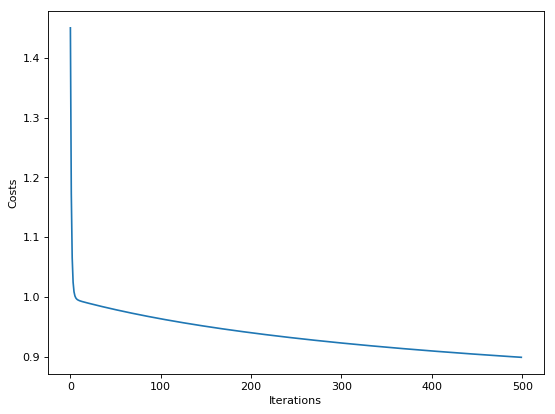

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_OH, test_size=.15, random_state = 42)
pred, W, b = model(X_train, Y_train, word_embedding)
print(pred)

### 1.3.3 - Examine performance on Test (Unseen) Data

Below we can see how the model performed on the training data and test data. While it is a significant increase from just randomly classifying each sentence in to one of the three labels, it still may not have significant value.

In [19]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_embedding)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_embedding)

Training set:
Accuracy: 0.587680754174323
Test set:
Accuracy: 0.5841628959276018


### 1.3.4 - Looking at Mislabeled Examples

Below we see the mislabeled examples, which showcases a critical issue. Because Bag-Of-Words does not preserve word order, it performs very poorly and can actually be harmful in the financial domain.

In [20]:
Y_val = np.zeros((len(Y_test), 1))
for j in range(len(Y_test)):
    Y_val[j] = np.argmax(Y_test[j])

Y_val[Y_val == 0] = -1
Y_val[Y_val == 1] = 0
Y_val[Y_val == 2] = 1

N_ex = 0
for i in range(len(Y_test)):
    if pred_test[i] != Y_val[i]:
        print(X_test[i] + 'Expected Sentiment:'+ str(Y_val[i]) + ', Prediction: '+ str(pred_test[i]))
        N_ex += 1
        if N_ex > 3:
            break
    

Selling and distribution expenses increased 13% in the first nine month driven by higher own retail expenditures, as well as a step up in brand communication.Expected Sentiment:[-1.], Prediction: [1.]
We grew adjusted earnings per share at 9% over the prior year quarter and EBITDA from operating segments grew 8%.Expected Sentiment:[0.], Prediction: [1.]
Turning to slide 6, our Well Intervention utilization was at 73% in Q1, slightly down from 74% in Q4 2017.Expected Sentiment:[-1.], Prediction: [1.]
We maintained our cash dividend for the third quarter at $0.155 per common share and we've repurchased $237 million of our common stock this year, with $99 million repurchased from the third quarter alone.Expected Sentiment:[0.], Prediction: [1.]


## 2. Financial-Sentiment-V2 Using Sequential Neural Networks

### 2.1 Model Overview

Text datasets are generally directional datasets, where the context/meaning depends on the ordering of each word within that sentence. Sequential Neural Networks provide us with a way to analyze these datasets in contextual manner than being completely statistical. Below, we will see two types of networks: 1) Recurrent Neural Networks (RNN), and 2) Long Short Term Memory Units (LSTM) and compare these with the model built above.

An essential component of a neural network analyzing text data is the Embedding Layer. This embedding layer serves as the bridge between $text$ and its $numerical$ $representation$ that the machine processes.

### 2.2 Embedding Layer

The embedding layer takes as input the indices of each word in the sentence and outputs the corresponding word vector representation. This embedding layer can use pre-trained word embedding vectors, or these can be tuned/trained on the fly as well. In the models below we will use the same pre-trained GloVe embeddings as above.

<img src='EmbeddingLayer.png'>

Run the following cell to load the required packages and libraries.

In [21]:
import numpy as np
np.random.seed(0)
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
np.random.seed(1)

We will again need to clean up the text as a pre-processing step for input to the neural networks.

In [22]:
def clean_document(s):
    regex = re.compile('[%s]' % re.escape(string.punctuation + '\n\n' + '\t\t'))
    doco_clean = regex.sub('', s)
    doco_clean = doco_clean.split(' ');
    doco_clean = [word.lower() for word in doco_clean if len(word) > 0];
    return doco_clean;

Let's load the data again and do some pre-processing for our labels, i.e. convert these to one-hot-encodings, and clean up the sentences from the earnings calls.

In [23]:
Data = pd.read_csv('EC_Data.csv')
X = list(Data['Sentence'])
Y = Data['MyScore']

y = Y
y[Y > 0] = 1
y[Y < 0] = 2

# Obtain a One-hot Y array for each sentence label.
y = to_categorical(y);

X_clean = [clean_document(doc) for doc in X];
sentences = [' '.join(r) for r in X_clean]


/Users/sahil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sahil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Next, we will tokenize each word in the dataset to unique identifier for that word, which could then be used by the embedding layer to convert this index to its corresponding word vector representation. Here, we will again use the pre-trained GloVe embeddings.

In [24]:
tokenizer = Tokenizer();
tokenizer.fit_on_texts(sentences);
text_sequences = np.array(tokenizer.texts_to_sequences(sentences));
sequence_dict = tokenizer.word_index;
word_dict = dict((num, val) for (val, num) in sequence_dict.items());

Glove_dim = 50
embeddings_index = dict();
with open('/srv/data/shared_data/glove.6B.50d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
        
vocab_size = len(sequence_dict);
embeddings_matrix = np.zeros((vocab_size+1, Glove_dim));
for word, i in sequence_dict.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

# Generate encoded sentences
sentences_encoded = [];
for i,sentence in enumerate(X_clean):
    sentences_encoded.append([sequence_dict[x] for x in sentence]);

Let's look at the distribution of the lengths of sentences in our dataset. This would allow us to fix the length of the sentence that goes as input to the network.

Text(0, 0.5, 'Number of sentences')

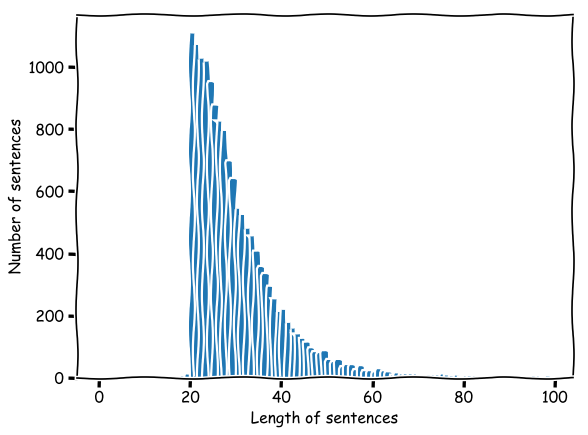

In [25]:
# Plot a Histogram of length of sentences
lengths = [len(x) for x in sentences_encoded];
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
with plt.xkcd():
    plt.hist(lengths, bins=range(100))  
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')


The histogram above shows that we could use a cap of 50 words for each sentence as almost all of the distribution is captured at this length.

Next, we will truncate all sentences for a cap of 50 words and pad those sentences with length less than 50. We will also randomny shuffle the data, so as not to overfit the neural network to any particular part of the data.

In [26]:
# Truncate and Pad sentences at a Maximum cap of 50 words.
max_cap = 50;
X_pad = pad_sequences(sentences_encoded, maxlen=max_cap, truncating='post', padding='post')

# Get a randomized sequence of positions to shuffle sentences
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

# Shuffle X and Y
X_pad = X_pad[random_posits];
y = y[random_posits];

As the last step before the model, we need to split the data in to training and test sets.

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pad,y, test_size=.15, random_state = 42)

### 2.3 Building the Model

Below, we will implement two models using RNNs and LSTMs. In both cases, we will start with the embedding layer which then feeds in to the RNN/LSTM units. This then goes in to a Feed Forward Neural Network and then finally to a classifier.

#### 2.3.1 Recurrent Neural Network

<img src='RNNcell.png'>

<img src='RNNeq.png'>

<img src='RNNnetwork.png'>

In [28]:
model_RNN = Sequential();
model_RNN.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap, weights=[embeddings_matrix], trainable=False));
model_RNN.add(SimpleRNN(60));
model_RNN.add(Dense(60, activation='relu'));
model_RNN.add(Dense(3, activation='softmax'));
print(model_RNN.summary());
optimizer = Adam(lr=0.01, decay=0.001);
model_RNN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
history_RNN = model_RNN.fit(X_train, Y_train, batch_size=64, epochs=10)

loss, acc = model_RNN.evaluate(X_test, Y_test)
print()
print("Test accuracy = ", acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            969650    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 60)                6660      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 183       
Total params: 980,153
Trainable params: 10,503
Non-trainable params: 969,650
_________________________________________________________________
None
Epoch 1/10
12517/12517 [==============================] - 6s 458us/step - loss: 0.5954 - acc: 0.6672
Epoch 2/10
12517/12517 [==============================] - 4s 318us/step - loss: 0.5917 - acc: 0.6662
Epoch 3/10
12517/12517 [==============================] 

#### 2.3.2 LSTM

While RNN is a sequential neural network, it suffers from Vanishing/Exploding Gradients that act as Memory Loss. LSTM have more gates, and the ability to continuously transfer information, allowing it alleviate some of these issues.

<img src='LSTMunit.png'>

<img src='LSTMeq.png'>
Source: [deeplearning.ai]

<img src='LSTMnetwork.png'>

In [29]:
model_LSTM = Sequential();
model_LSTM.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap, weights=[embeddings_matrix], trainable=False));
model_LSTM.add(LSTM(60));
model_LSTM.add(Dense(60, activation='relu'));
model_LSTM.add(Dense(3, activation='softmax'));
print(model_LSTM.summary());
optimizer = Adam(lr=0.01, decay=0.001);
model_LSTM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
history_LSTM = model_LSTM.fit(X_train, Y_train, batch_size=64, epochs=10)

loss, acc = model_LSTM.evaluate(X_test, Y_test)
print()
print("Test accuracy = ", acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            969650    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                26640     
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 183       
Total params: 1,000,133
Trainable params: 30,483
Non-trainable params: 969,650
_________________________________________________________________
None
Epoch 1/10
12517/12517 [==============================] - 15s 1ms/step - loss: 0.5834 - acc: 0.6838
Epoch 2/10
12517/12517 [==============================] - 13s 1ms/step - loss: 0.4948 - acc: 0.7703
Epoch 3/10
12517/12517 [==============================] 

## Acknowledgements

We would like to thank everyone at Accrete for helping with this notebook. Some parts of this notebook use the deeplearning.ai coursework. Check out our github at https://github.com/accrete1/ContextualAnalysis